# Transfer learning with YAMNet for environmental sound classification

[YAMNet](https://tfhub.dev/google/yamnet/1) is a pre-trained deep neural network that can predict audio events from [521 classes](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv), such as laughter, barking, or a siren. 

 In this tutorial you will learn how to:

- Load and use the YAMNet model for inference.
- Build a new model using the YAMNet embeddings to classify cat and dog sounds.
- Evaluate and export your model.


## Import TensorFlow and other libraries


Start by installing [TensorFlow I/O](https://www.tensorflow.org/io), which will make it easier for you to load audio files off disk.

In [94]:
!pip install tensorflow_io

In [95]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

import soundfile as sf

## About YAMNet

[YAMNet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet) is a pre-trained neural network that employs the [MobileNetV1](https://arxiv.org/abs/1704.04861) depthwise-separable convolution architecture. It can use an audio waveform as input and make independent predictions for each of the 521 audio events from the [AudioSet](http://g.co/audioset) corpus.

Internally, the model extracts "frames" from the audio signal and processes batches of these frames. This version of the model uses frames that are 0.96 second long and extracts one frame every 0.48 seconds .

The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as single-channel (mono) 16 kHz samples in the range `[-1.0, +1.0]`. This tutorial contains code to help you convert WAV files into the supported format.

The model returns 3 outputs, including the class scores, embeddings (which you will use for transfer learning), and the log mel [spectrogram](https://www.tensorflow.org/tutorials/audio/simple_audio#spectrogram). You can find more details [here](https://tfhub.dev/google/yamnet/1).

One specific use of YAMNet is as a high-level feature extractor - the 1,024-dimensional embedding output. You will use the base (YAMNet) model's input features and feed them into your shallower model consisting of one hidden `tf.keras.layers.Dense` layer. Then, you will train the network on a small amount of data for audio classification _without_ requiring a lot of labeled data and training end-to-end. (This is similar to [transfer learning for image classification with TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) for more information.)

First, you will test the model and see the results of classifying audio. You will then construct the data pre-processing pipeline.

### Loading YAMNet from TensorFlow Hub

You are going to use a pre-trained YAMNet from [Tensorflow Hub](https://tfhub.dev/) to extract the embeddings from the sound files.

Loading a model from TensorFlow Hub is straightforward: choose the model, copy its URL, and use the `load` function.

Note: to read the documentation of the model, use the model URL in your browser.

In [96]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

With the model loaded, you can follow the [YAMNet basic usage tutorial](https://www.tensorflow.org/hub/tutorials/yamnet) and download a sample WAV file to run the inference.


In [97]:
from google.colab import drive
import os
from os import path

drive.mount('/content/drive')
if path.exists('/content/Data') == False:
  os.mkdir("/content/Data")
  !unrar x "/content/drive/MyDrive/Autism Detection/Data/Autism/Cry sounds.rar" "/content/Data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
testing_wav_file_name = "./Data/Cry sounds/original/ASD1/1.wav"

print(testing_wav_file_name)

./Data/Cry sounds/original/ASD1/1.wav


You will need a function to load audio files, which will also be used later when working with the training data. (Learn more about reading audio files and their labels in [Simple audio recognition](https://www.tensorflow.org/tutorials/audio/simple_audio#reading_audio_files_and_their_labels).

Note: The returned `wav_data` from `load_wav_16k_mono` is already normalized to values in the `[-1.0, 1.0]` range (for more information, go to [YAMNet's documentation on TF Hub](https://tfhub.dev/google/yamnet/1)).

In [99]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

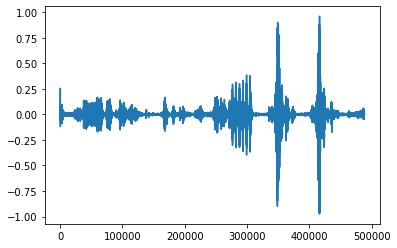

In [140]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data,rate=16000)

### Load the class mapping

It's important to load the class names that YAMNet is able to recognize. The mapping file is present at `yamnet_model.class_map_path()` in the CSV format.

In [141]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names = list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:]:
  print(name)

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
Baby cry, infant cry
Whimper
Wail, moan
Sigh
Singing
Choir
Yodeling
Chant
Mantra
Child singing
Synthetic singing
Rapping
Humming
Groan
Grunt
Whistling
Breathing
Wheeze
Snoring
Gasp
Pant
Snort
Cough
Throat clearing
Sneeze
Sniff
Run
Shuffle
Walk, footsteps
Chewing, mastication
Biting
Gargling
Stomach rumble
Burping, eructation
Hiccup
Fart
Hands
Finger snapping
Clapping
Heart sounds, heartbeat
Heart murmur
Cheering
Applause
Chatter
Crowd
Hubbub, speech noise, speech babble
Children playing
Animal
Domestic animals, pets
Dog
Bark
Yip
Howl
Bow-wow
Growling
Whimper (dog)
Cat
Purr
Meow
Hiss
Caterwaul
Livestock, farm animals, working animals
Horse
Clip-clop
Neigh, whinny
Cattle, bovinae
Moo
Cowbell
Pig
Oink
Goat
Bleat
Sheep
Fowl
Chicken, rooster
Cluck
Crowi

### Run inference

YAMNet provides frame-level class-scores (i.e., 521 scores for every frame). In order to determine clip-level predictions, the scores can be aggregated per-class across frames (e.g., using mean or max aggregation). This is done below by `scores_np.mean(axis=0)`. Finally, to find the top-scored class at the clip-level, you take the maximum of the 521 aggregated scores.


In [142]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Laughter
The embeddings shape: (63, 1024)


In [143]:
top_classes = 5
values, indices = tf.nn.top_k(class_scores,top_classes)
for rank in range(top_classes):
    print((rank + 1), class_names[indices[rank]])

1 Laughter
2 Inside, small room
3 Speech
4 Giggle
5 Belly laugh


In [149]:
path = "./Data/Cry sounds/cleaned"
filenames = []
targets = []
folds = []
ASD_counter = 0
TD_counter = 0
for root, directories, files in os.walk(path, topdown=False):
  for name in files:
    if (sf.SoundFile(os.path.join(root, name))).subtype == "PCM_U8":
      continue
    if "ASD" in os.path.join(root, name):   
      targets.append(1)
      folds.append((ASD_counter%5) + 1)
      ASD_counter += 1
      filenames.append(os.path.join(root, name))
    elif "TD" in os.path.join(root, name):
      for i in range(3):
        targets.append(0)
        folds.append((TD_counter%5) + 1)
        TD_counter += 1
        filenames.append(os.path.join(root, name))
      
print("Number of ASD samples:", ASD_counter)
print("Number of TD samples:", int(TD_counter / 3))
print(len(filenames))
print(len(targets))
print(len(folds))
list_of_tuples = list(zip(filenames, folds, targets)) 
df = pd.DataFrame(list_of_tuples, columns = ['filename', 'fold', 'target'])

Number of ASD samples: 191
Number of TD samples: 168
695
695
695


In [150]:
df

,filename,fold,target
0,./Data/Cry sounds/cleaned/TD27/1_5.wav,1,0
1,./Data/Cry sounds/cleaned/TD27/1_5.wav,2,0
2,./Data/Cry sounds/cleaned/TD27/1_5.wav,3,0
3,./Data/Cry sounds/cleaned/TD27/1_2.wav,4,0
4,./Data/Cry sounds/cleaned/TD27/1_2.wav,5,0
...,...,...,...
690,./Data/Cry sounds/cleaned/ASD26/1_5.wav,2,1
691,./Data/Cry sounds/cleaned/ASD26/1_2.wav,3,1
692,./Data/Cry sounds/cleaned/ASD26/1_3.wav,4,1
693,./Data/Cry sounds/cleaned/ASD26/1_4.wav,5,1


In [151]:
filenames = df['filename']
targets = df['target']
folds = df['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [152]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [153]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### Split the data

You will use the `fold` column to split the dataset into train, validation and test sets.

ESC-50 is arranged into five uniformly-sized cross-validation `fold`s, such that clips from the same original source are always in the same `fold` - find out more in the [ESC: Dataset for Environmental Sound Classification](https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf) paper.

The last step is to remove the `fold` column from the dataset since you're not going to use it during training.


In [154]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold <= 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Create your model

You did most of the work!
Next, define a very simple [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model with one hidden layer and two outputs to recognize cats and dogs from sounds.


In [155]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               524800    
                                                                 
 dense_19 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [156]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=5,
                                            restore_best_weights=True)

In [157]:
history = my_model.fit(train_ds,
                       epochs=100,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/100
28/28 [==============================] - 23s 33ms/step - loss: 0.5623 - accuracy: 0.7435 - val_loss: 0.4943 - val_accuracy: 0.7806
Epoch 2/100
28/28 [==============================] - 0s 17ms/step - loss: 0.4502 - accuracy: 0.8002 - val_loss: 0.5008 - val_accuracy: 0.7764
Epoch 3/100
28/28 [==============================] - 1s 20ms/step - loss: 0.4043 - accuracy: 0.8297 - val_loss: 0.4271 - val_accuracy: 0.8059
Epoch 4/100
28/28 [==============================] - 1s 26ms/step - loss: 0.3679 - accuracy: 0.8547 - val_loss: 0.4159 - val_accuracy: 0.8270
Epoch 5/100
28/28 [==============================] - 1s 20ms/step - loss: 0.3353 - accuracy: 0.8615 - val_loss: 0.4574 - val_accuracy: 0.8059
Epoch 6/100
28/28 [==============================] - 0s 18ms/step - loss: 0.3055 - accuracy: 0.8854 - val_loss: 0.3913 - val_accuracy: 0.8397
Epoch 7/100
28/28 [==============================] - 1s 26ms/step - loss: 0.2695 - accuracy: 0.8978 - val_loss: 0.3688 - val_accuracy: 0.8439
Epoch

Let's run the `evaluate` method on the test data just to be sure there's no overfitting.

You did it!

## Test your model

Next, try your model on the embedding from the previous test using YAMNet only.


In [158]:
my_classes = ["TD", "ASD"]
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: ASD


## Save a model that can directly take a WAV file as input

Your model works when you give it the embeddings as input.

In a real-world scenario, you'll want to use audio data as a direct input.

To do that, you will combine YAMNet with your model into a single model that you can export for other applications.

To make it easier to use the model's result, the final layer will be a `reduce_mean` operation. When using this model for serving (which you will learn about later in the tutorial), you will need the name of the final layer. If you don't define one, TensorFlow will auto-define an incremental one that makes it hard to test, as it will keep changing every time you train the model. When using a raw TensorFlow operation, you can't assign a name to it. To address this issue, you'll create a custom layer that applies `reduce_mean` and call it `'classifier'`.


In [159]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [160]:
saved_model_path = './yamnet_model'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


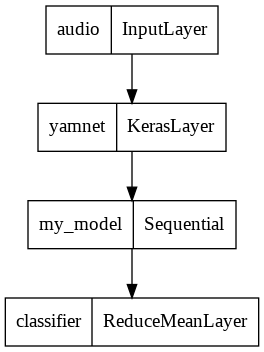

In [161]:
tf.keras.utils.plot_model(serving_model)

Load your saved model to verify that it works as expected.

In [162]:
reloaded_model = tf.saved_model.load(saved_model_path)

And for the final test: given some sound data, does your model return the correct result?

In [163]:
reloaded_results = reloaded_model(testing_wav_data)
ASD_or_TD = my_classes[tf.argmax(reloaded_results)]
print(f'The main sound is: {ASD_or_TD}')

The main sound is: ASD


If you want to try your new model on a serving setup, you can use the 'serving_default' signature.

In [164]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
ASD_or_TD = my_classes[tf.argmax(serving_results['classifier'])]
print(f'The main sound is: {ASD_or_TD}')

The main sound is: ASD
